# Tratamento estatístico de dados climatológicos
Baseado nos dados do INMET: https://portal.inmet.gov.br/dadoshistoricos

Carregar a biblioteca de confiabilidade pelo terminal do VS Code: 

        python -m venv myenv
        myenv/bin/pip install reliability

Mudar o kernel para o venv (o VS Code deve reconhecer)

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from urllib.request import urlretrieve
from zipfile import ZipFile 
import matplotlib.pyplot as plt
# from reliability.Distributions import Normal_Distribution
# from reliability.Probability_plotting import Normal_probability_plot
# Testando com Scipy - o pacote Reliabiltiy precisa de virtual environment
from scipy import stats

# Teste de combobox - a ideia é selecionar um ano e uma estação, baixar o zip do ano e extrair
dpEstacoes = widgets.Dropdown(
    options=[('One', 1), ('Two', 2), ('Three', 3)],
    value=2,
    description='Number:',
)
display(dpEstacoes);
ano = '2023'
estacao = 'SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL' # checar se a convenção de nome se mantém nos anos

Dropdown(description='Number:', index=1, options=(('One', 1), ('Two', 2), ('Three', 3)), value=2)

## Carregando base (pode pular se o arquivo for o mesmo)

In [2]:
url = 'https://portal.inmet.gov.br/uploads/dadoshistoricos/2023.zip'
arqzip = '2023.zip'
arq = 'INMET_SE_RJ_A618_TERESOPOLIS-PARQUE NACIONAL_01-01-2023_A_31-12-2023.CSV'
urlretrieve(url, arqzip)
with ZipFile(arqzip) as zObject:
    zObject.extract(arq) 
df = pd.read_csv(arq, sep=';', skiprows=8, encoding='latin1', decimal=',')

In [48]:
df

,Data,Hora UTC,precTotal,"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),tempMax,...,TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))",ventoRaj,ventoHor,Unnamed: 19,date
0,2023/01/01,0000 UTC,0.4,908.9,908.9,908.4,0.0,18.6,15.9,18.9,...,17.8,15.9,95.0,84.0,84.0,251.0,6.3,1.4,NaN,2023-01-01 00:00:00+00:00
1,2023/01/01,0100 UTC,0.4,908.4,909.1,908.2,0.3,19.1,13.5,19.1,...,15.8,13.5,89.0,70.0,70.0,255.0,5.2,1.9,NaN,2023-01-01 01:00:00+00:00
2,2023/01/01,0200 UTC,0.0,908.0,908.4,908.0,1.0,19.9,16.9,20.0,...,16.9,13.7,89.0,70.0,83.0,266.0,6.2,1.8,NaN,2023-01-01 02:00:00+00:00
3,2023/01/01,0300 UTC,0.0,907.6,908.1,907.6,0.2,19.3,16.1,20.0,...,16.8,16.0,84.0,80.0,81.0,263.0,6.2,1.4,NaN,2023-01-01 03:00:00+00:00
4,2023/01/01,0400 UTC,0.0,906.9,907.6,906.9,0.0,19.2,16.0,19.8,...,16.1,15.4,83.0,78.0,82.0,264.0,4.5,1.5,NaN,2023-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023/12/31,1900 UTC,0.0,907.0,907.4,907.0,459.3,18.0,16.6,18.3,...,17.2,16.3,94.0,91.0,92.0,327.0,2.2,0.5,NaN,2023-12-31 19:00:00+00:00
8756,2023/12/31,2000 UTC,0.0,906.7,907.0,906.6,299.8,17.9,16.5,18.5,...,17.1,16.1,93.0,89.0,92.0,19.0,1.3,0.5,NaN,2023-12-31 20:00:00+00:00
8757,2023/12/31,2100 UTC,0.0,907.0,907.0,906.6,105.3,17.6,16.7,18.1,...,16.9,16.1,95.0,89.0,95.0,113.0,1.0,0.2,NaN,2023-12-31 21:00:00+00:00
8758,2023/12/31,2200 UTC,0.0,907.3,907.3,907.0,9.9,17.0,16.1,17.6,...,16.7,16.0,95.0,92.0,94.0,190.0,2.0,0.4,NaN,2023-12-31 22:00:00+00:00


## Alguns histogramas

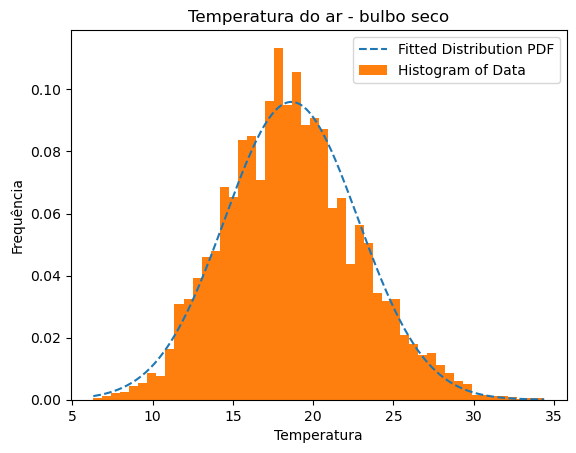

In [5]:
df = df.rename(columns={
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)" : "precTotal", 
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "pMed", 
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "tMed",
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)": "tMax", 
    "VENTO, RAJADA MAXIMA (m/s)": "ventoRaj", 
    "VENTO, VELOCIDADE HORARIA (m/s)": "ventoHor"})
dfTarSeco = df.iloc[:,7]
dist = stats.norm
res = stats.fit(dist, dfTarSeco[np.isfinite(dfTarSeco)], [(0, 40), (0.5, 5)])
fig, ax = plt.subplots(1,1)
res.plot(ax)
plt.xlabel('Temperatura')
plt.ylabel('Frequência')
plt.title('Temperatura do ar - bulbo seco')
plt.show()

/usr/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:2511: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


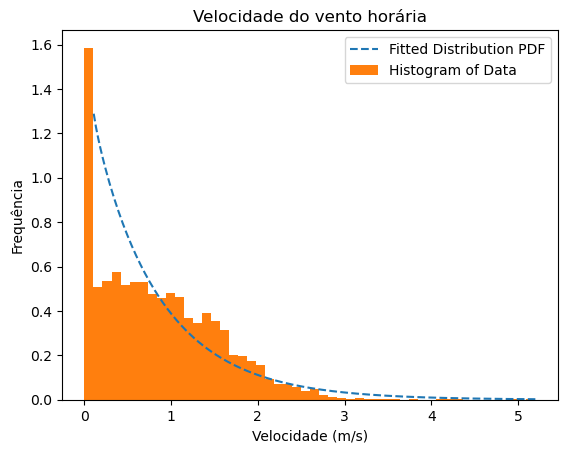

  params: FitParams(c=0.9800862873884687, loc=0.08133346431696742, scale=0.7860587208521557)
 success: False
 message: 'Optimization converged to parameter values that are inconsistent with the data.'

In [5]:
# TODO: tratar os dados zerados
dfVento = df.iloc[:,18]
dist = stats.weibull_min
res = stats.fit(dist, dfVento[np.isfinite(dfVento)], [(0, 1), (0, 5), (0.1, 5)])
fig, ax = plt.subplots(1,1)
res.plot(ax)
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Frequência')
plt.title('Velocidade do vento horária')
plt.show()
res

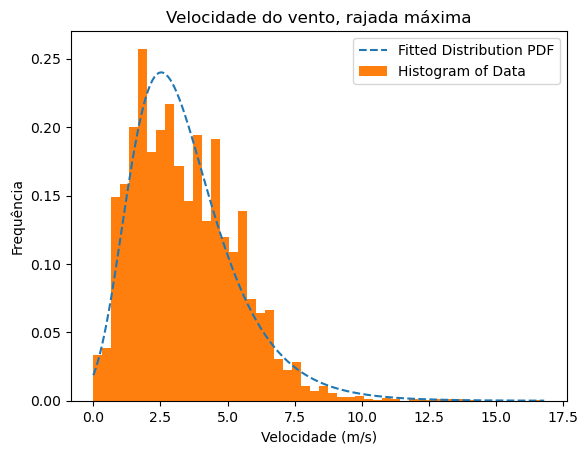

  params: FitParams(loc=2.5285586185806483, scale=1.5326116459542116)
 success: True
 message: 'Optimization terminated successfully.'

In [20]:
dfRaj = df.iloc[:,17]
dist = stats.gumbel_r
res = stats.fit(dist, dfRaj[np.isfinite(dfRaj)], [(0, 20), (0.5, 5)])
fig, ax = plt.subplots(1,1)
res.plot(ax)
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Frequência')
plt.title('Velocidade do vento, rajada máxima')
plt.show()
res

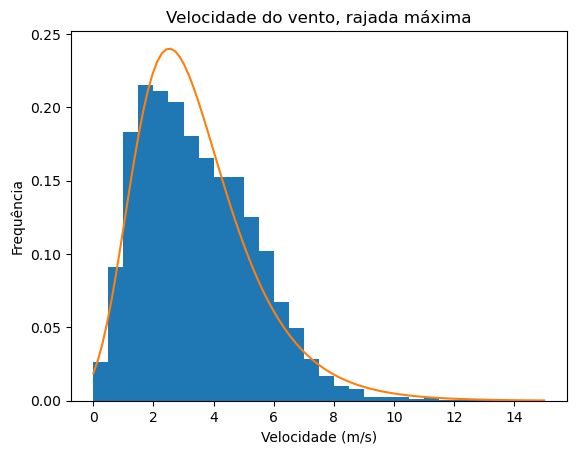

  params: FitParams(loc=2.5285586185806483, scale=1.5326116459542116)
 success: True
 message: 'Optimization terminated successfully.'

In [21]:
fig, ax = plt.subplots(1,1)
ax.hist(dfRaj, bins=np.arange(0., 15.5, 0.5), density=True);
x = np.linspace(0, 15, 100)
ax.plot(x, stats.gumbel_r.pdf(x, *res.params))
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Frequência')
plt.title('Velocidade do vento, rajada máxima')
plt.show()
res

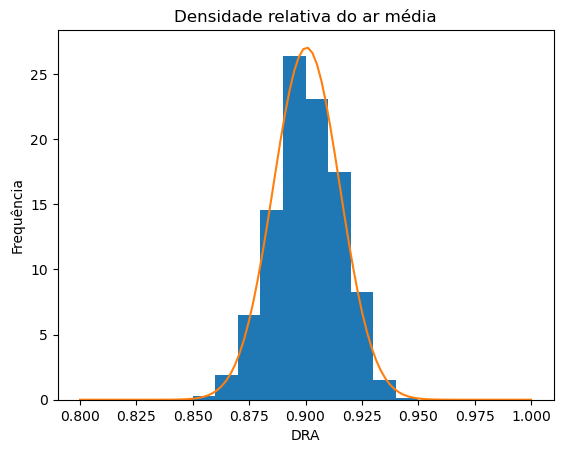

  params: FitParams(loc=0.9004584708840868, scale=0.014757838628102867)
 success: True
 message: 'Optimization terminated successfully.'

In [18]:
df['dra'] = df['pMed']/1013 * (293)/(273 + df['tMed'])
dfDra = df['dra']
dist = stats.norm
res = stats.fit(dist, dfDra[np.isfinite(dfDra)], [(0.5, 1), (0.01, 2)])
fig, ax = plt.subplots(1,1)
ax.hist(dfDra, bins=np.arange(0.8, 1, 0.01), density=True);
x = np.linspace(0.8, 1, 100)
ax.plot(x, stats.norm.pdf(x, *res.params))
plt.xlabel('DRA')
plt.ylabel('Frequência')
plt.title('Densidade relativa do ar média')
plt.show()
res

## Testes de correlação

TODO: correlacionar os dados para tentar preencher os buracos em algumas séries

In [22]:
df['date'] = df.iloc[:,0] + ' ' + df.iloc[:,1]
df['date'] = pd.to_datetime(df['date'])
df.corr()

/tmp/ipykernel_225436/3828080847.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,precTotal,pMed,PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),tMed,TEMPERATURA DO PONTO DE ORVALHO (°C),tempMax,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))",ventoRaj,ventoHor,Unnamed: 19,dra
precTotal,1.000000,-0.042660,-0.043267,-0.057559,-0.092800,-0.045247,0.078857,-0.026900,-0.032155,0.082558,0.089368,0.147186,0.143210,0.158671,-0.046855,0.084045,-0.004249,NaN,0.028559
pMed,-0.042660,1.000000,0.996848,0.996938,-0.026468,-0.527151,-0.588599,-0.527759,-0.555840,-0.594773,-0.575394,0.104509,0.111386,0.089308,-0.114040,-0.201180,-0.124621,NaN,0.677141
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),-0.043267,0.996848,1.000000,0.997315,0.003493,-0.510949,-0.588425,-0.512117,-0.540433,-0.591053,-0.577825,0.084084,0.091572,0.068377,-0.115273,-0.183211,-0.108098,NaN,0.662566
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),-0.057559,0.996938,0.997315,1.000000,-0.003905,-0.515888,-0.590645,-0.517059,-0.544696,-0.594531,-0.579285,0.087217,0.095047,0.072138,-0.112590,-0.194584,-0.116473,NaN,0.666898
RADIACAO GLOBAL (Kj/m²),-0.092800,-0.026468,0.003493,-0.003905,1.000000,0.608181,0.109742,0.596902,0.540546,0.210076,0.002599,-0.648446,-0.693776,-0.708584,-0.092101,0.498909,0.506283,NaN,-0.528424
tMed,-0.045247,-0.527151,-0.510949,-0.515888,0.608181,1.000000,0.676796,0.987062,0.984024,0.742306,0.591448,-0.626104,-0.657135,-0.649318,0.007798,0.475333,0.411677,NaN,-0.982049
TEMPERATURA DO PONTO DE ORVALHO (°C),0.078857,-0.588599,-0.588425,-0.590645,0.109742,0.676796,1.000000,0.668410,0.705160,0.978096,0.975523,0.112515,0.056693,0.109493,0.021857,0.109878,0.052132,NaN,-0.720994
tempMax,-0.026900,-0.527759,-0.512117,-0.517059,0.596902,0.987062,0.668410,1.000000,0.981655,0.742423,0.577429,-0.631661,-0.684335,-0.643455,0.011022,0.480468,0.398534,NaN,-0.970852
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),-0.032155,-0.555840,-0.540433,-0.544696,0.540546,0.984024,0.705160,0.981655,1.000000,0.765380,0.630225,-0.605640,-0.617046,-0.594279,0.011203,0.451369,0.372479,NaN,-0.974759
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),0.082558,-0.594773,-0.591053,-0.594531,0.210076,0.742306,0.978096,0.742423,0.765380,1.000000,0.949405,0.031089,-0.043788,0.004918,0.021838,0.160096,0.097754,NaN,-0.778235


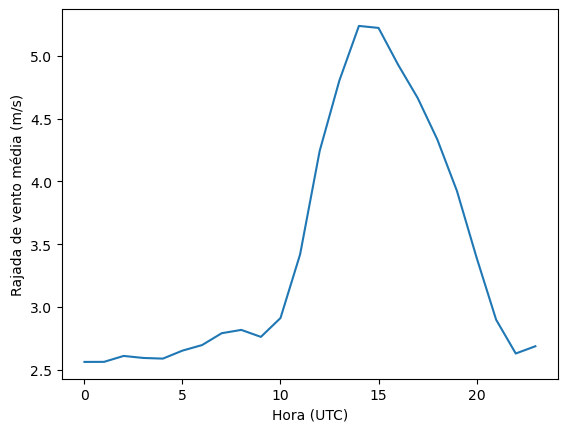

In [50]:
df.groupby(df['date'].dt.hour)['ventoRaj'].mean().plot()
plt.xlabel("Hora (UTC)");
plt.ylabel("Rajada de vento média (m/s)");

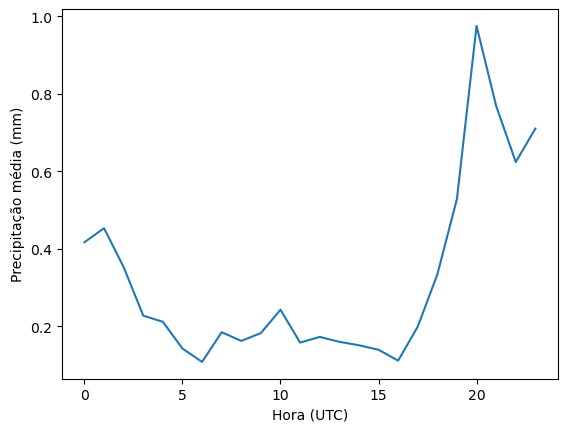

In [51]:
df.groupby(df['date'].dt.hour)['precTotal'].mean().plot()
plt.xlabel("Hora (UTC)");
plt.ylabel("Precipitação média (mm)");

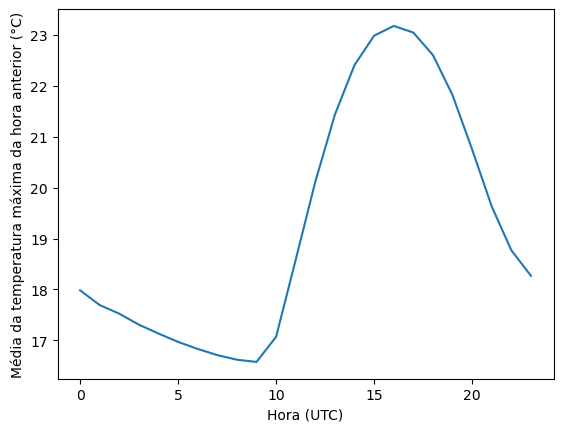

In [53]:
df.groupby(df['date'].dt.hour)['tempMax'].mean().plot()
plt.xlabel("Hora (UTC)");
plt.ylabel("Média da temperatura máxima da hora anterior (°C)");